In [51]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# Set some switches

In [52]:
do_sa = False # For seasonal adjustment
select_vars_manual = False # Set to true if you want to choose variables manually
use_custom_weights = False # If we want to use customised weights
generate_plots = False # Choose whther to generate plots

# Put your chosen variables here
manual_vars = ['Export Value', 'Import Value']


# Load Data

In [53]:
# os.listdir()

In [54]:
filename = 'Composite Index March 2025.xlsx'
sheets = pd.ExcelFile(filename).sheet_names

# sheets
df = pd.read_excel(filename, sheet_name="Data ")
df.columns = df.columns.str.strip()

metadata = df.loc[[i for i in range(4)], :]
df.drop(index=[i for i in range(4)], inplace=True)


# change to numeric
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Description'] = pd.to_datetime(df['Description'], format="%Y-%m-%d %H-%M-%S").dt.normalize()
df = df.set_index(df['Description'], drop=True)
df.drop(columns=['Description'], inplace=True)
# df['Description']


df.head()

,CPI,Credit to private sector,M3,VAT,Tourism receipts,Total electricity production,Gold exports,Total Expenditure,Cement production,Excise Duty,...,Recurrent expenditure,Development expenditure,REER,Export Value,Import volume,Import Value,Mobile payment volume,Mobile payment Value,Voice traffic,Tourist arrivals
Description,,,,,,,,,,,,,,,,,,,,,
2002-01-01,28.135813,540161.223218,1.888993e+06,30915.4,45978.748602,218664473.0,27654.600656,158907.390843,76.363746,6792.9,...,89345.205192,69562.185651,68.890232,74697.964149,232039.0,114562.042573,NaN,NaN,NaN,NaN
2002-02-01,28.719591,546360.065167,1.965306e+06,27347.9,43898.693138,204938943.0,21548.215176,115955.800000,74.021281,5611.9,...,83797.900000,32157.900000,71.237777,58761.923346,247251.0,127967.485563,NaN,NaN,NaN,NaN
2002-03-01,28.886716,563539.319393,1.979213e+06,26682.0,44493.123026,237046241.0,21887.901461,133613.700000,74.614973,5560.2,...,96199.000000,37414.700000,72.965875,63894.430989,320015.0,112986.452913,NaN,NaN,NaN,NaN
2002-04-01,29.316835,546975.154900,1.975192e+06,30851.8,38743.664182,220432110.0,29419.286974,111452.600000,78.144861,7027.8,...,82647.700000,28804.900000,73.373064,74774.164535,257775.0,119898.305467,NaN,NaN,NaN,NaN
2002-05-01,29.667001,571315.733460,1.984940e+06,29892.4,40206.863306,236285657.0,31968.322368,121758.840000,82.168623,4761.9,...,96419.840000,25339.000000,74.494101,74256.643607,236824.0,126546.652137,NaN,NaN,NaN,NaN


### Manual weights
- You need to make sure you have an excel file with manually chosen weights
- Otherwise, to make life easier you can make use of python dictionary to assig your weights

In [55]:
print(manual_vars)

['Export Value', 'Import Value']


In [56]:
# Use this if you have weights file, [tedious]
if use_custom_weights:
    try:
        df_weights = pd.read_excel('weights.xlsx')
        df_weights.columns = df_weights.columns.str.strip()
        custom_weights = df_weights.to_dict(orient='records')[0]
        df_weights.columns = df_weights.columns.str.strip()
        custom_weights = df_weights.to_dict(orient='records')[0]
    except Exception as e:
        print(f"Error: {e}")
        print("Please add your weights.xlsx file")

    # Using weight dictionary, uncomment to use dictionary instead of weights file Example
    # user_weights = {}
    # user_weights['Export Value'] = 1
    # user_weights['Import Value'] = 1

    # custom_weights = user_weights

### GDP data

In [57]:
gdp = pd.read_excel(filename, sheet_name="GDP")

# Generate GDP index
base = "2015Q1"
gdp['gdp_index'] = 100*gdp['GDP Actual']/gdp.loc[gdp['yq']==base,'GDP Actual'].values[0]
# Format GDP data
gdp.set_index(pd.PeriodIndex(gdp['yq'].str.strip(), freq='Q'), inplace=True)
gdp.tail(5)

,yq,GDP Actual,gdp_index
yq,,,
2023Q4,2023Q4,3.986150e+07,175.003189
2024Q1,2024Q1,3.873069e+07,170.038639
2024Q2,2024Q2,3.836620e+07,168.438428
2024Q3,2024Q3,3.752225e+07,164.733261
2024Q4,2024Q4,4.194216e+07,184.137882


### Deflating Nominal variables
 - CPI is used as a deflator

In [58]:
# Identify nominal variables using metadata, Nominal variables are denoted as N
data_type_map0 = metadata.loc[metadata['Description']=='Type', :].to_dict(orient='records')[0]
data_type_map  = {k:str(v).strip() for k,v in data_type_map0.items()}

nominal = [k for k,v in data_type_map.items() if re.search(r'^N$', v)]

# Convert to real
# real = {}
df1 = df.copy()
for col in nominal:
    df1[col] = df1[col]/df['CPI']

df1.tail(5)

,CPI,Credit to private sector,M3,VAT,Tourism receipts,Total electricity production,Gold exports,Total Expenditure,Cement production,Excise Duty,...,Recurrent expenditure,Development expenditure,REER,Export Value,Import volume,Import Value,Mobile payment volume,Mobile payment Value,Voice traffic,Tourist arrivals
Description,,,,,,,,,,,,,,,,,,,,,
2024-12-01,116.865361,308880.351705,418473.197076,7349.171162,8268.233692,1.056765e+09,7316.897066,33141.912828,713.172690,1688.705565,...,20647.653381,12494.259447,95.168946,19835.027101,1.940639e+06,29674.215042,6.287554e+08,167021.033219,1.437069e+10,217655.0
2025-01-01,117.574370,311089.130263,423854.919583,6459.398096,7066.384876,1.040629e+09,7005.491707,30467.444179,771.083523,1647.928464,...,20055.760254,10411.683925,98.155912,15518.830793,1.830374e+06,21858.576840,6.580988e+08,165746.087439,1.410032e+10,195487.0
2025-02-01,118.278313,312673.874948,427726.195627,5629.077622,7153.790483,1.021412e+09,7876.474192,32459.019096,758.956941,1575.239936,...,20054.727691,12404.291405,96.822793,14577.645186,1.677775e+06,20751.690410,5.693264e+08,148316.414655,1.250255e+10,190313.0
2025-03-01,119.268527,318602.734040,437180.624402,5576.314825,5102.424274,1.111440e+09,7962.850051,29040.864513,747.737718,1410.741162,...,16504.009506,12536.855007,99.232278,15886.769287,1.790816e+06,29607.776496,6.346585e+08,166658.900624,1.396560e+10,140597.0
2025-04-01,119.780635,323556.696094,445295.007641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Time series plots

### Levels

In [59]:
if generate_plots:
    vars = df1.columns
    import matplotlib.dates as mdates
    def lineplots(vars, df, ncols=4, interval=4):
        fig, axs = plt.subplots(ncols=ncols, nrows=(len(vars) + ncols - 1) // ncols, figsize=(25, 30))
        axs = axs.ravel()

        date_format = mdates.DateFormatter('%b-%y')
        # date_locator = mdates.MonthLocator(interval=interval)

        for ax, col in zip(axs, vars):
            sns.lineplot(data=df, x=df.index, y=col, ax=ax)
            ax.xaxis.set_major_formatter(date_format)
            # ax.xaxis.set_major_locator(date_locator)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title(f"{col}")
            for label in ax.get_xticklabels():
                label.set_rotation(45)

        plt.tight_layout()
        plt.show()

    lineplots(vars,df1)


# HP-filtering and Visualisation

In [60]:

import pandas as pd
import statsmodels.api as sm

smooth_data = False

if smooth_data:
    for col in df1.columns:
        # print(col)
        try:
            cycle, trend = sm.tsa.filters.hpfilter(df1[col].dropna(), lamb=0.5)  # lambda=1600 for quarterly data
            df1[col] = trend
        except Exception as e:
            print(f"{col}: {e}")
            df1[col] = df1[col]

# Apply HP filter
if generate_plots:
    lineplots(vars,df1)

## Identify and remove outliers

In [61]:
remove_outliers = True

if remove_outliers:
    def remove_outliers_iqr(data, columns):
        data = data.copy()
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Find outliers
            outliers = (data[col] < lower_bound) | (data[col] > upper_bound)

            # Replace outliers with the previous (lagged) value
            data.loc[outliers, col] = data[col].shift(12)
            if data.loc[outliers, col].shape[0]:
                print(f"{col}: {list(pd.PeriodIndex(data.loc[outliers, col].index, freq='Q').astype(str))}")
        return data

df1 = remove_outliers_iqr(df1, df1.columns)

if generate_plots:
    lineplots(vars,df1)

VAT: ['2024Q4', '2024Q4']
Tourism receipts: ['2023Q3', '2023Q4', '2024Q3', '2024Q3', '2024Q3', '2024Q4', '2024Q4']
Total electricity production: ['2024Q3', '2024Q4', '2024Q4', '2024Q4', '2025Q1', '2025Q1', '2025Q1']
Fuel prices: ['2008Q4', '2008Q4', '2009Q1', '2009Q1', '2009Q1', '2009Q3', '2009Q3', '2009Q4', '2009Q4', '2009Q4', '2010Q1', '2010Q1', '2010Q1', '2010Q2', '2010Q2', '2010Q2', '2010Q3', '2010Q3', '2010Q3']
Total deposits in the Banking system: ['2024Q3', '2024Q3', '2024Q4', '2024Q4', '2024Q4', '2025Q1', '2025Q1', '2025Q1', '2025Q2']
Volume of oil imports: ['2013Q2', '2014Q1']
Recurrent expenditure: ['2019Q2']
Development expenditure: ['2018Q2', '2021Q4']
REER: ['2002Q1', '2006Q3']
Export Value: ['2024Q3', '2024Q3', '2024Q4', '2024Q4']
Import Value: ['2022Q3', '2024Q3']
Mobile payment volume: ['2024Q2', '2024Q3', '2024Q3', '2024Q3', '2024Q4', '2024Q4', '2024Q4', '2025Q1', '2025Q1', '2025Q1']
Mobile payment Value: ['2024Q4', '2025Q1', '2025Q1']
Tourist arrivals: ['2020Q2', '202

# Seasonal adjustment
- Make sure you download the `x13as` file you can get it from [here](https://sourceforge.net/projects/gretl/files/x13as/)
- Set the correct path as shown in the cell below

In [62]:
import os
import warnings

from statsmodels.tsa.x13 import x13_arima_analysis
from statsmodels.tsa.x13 import X13Warning

warnings.filterwarnings("ignore", category=X13Warning)

# Set the correct path to your X13 executable
x13path = r"C:\x13as\x13as.exe"  # Use raw string (r prefix) for Windows paths
os.environ["X13PATH"] = x13path


try:
    # to_drop = ['Mobile payment volume','Mobile payment Value', 'Voice traffic', 'Tourist arrivals', 'Fuel prices']
    to_drop = ['Fuel prices']
    df1.drop(columns=to_drop, inplace=True)
except Exception as e:
    print(e)

try:
    # df1 = df1.set_index('Description', drop=False)
    df1 = df1.asfreq('MS')  # monthly start
except Exception as e:
    print(e)

# Seasonal adjustment
# df2 = df1.copy()
if do_sa:
    for col in df1.columns:
        try:
            # Pass the series data, not just column name
            series = df1[col].dropna()
            result = x13_arima_analysis(series, x12path=x13path)
            df1[f"sa_{col}"] = result.seasadj
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
            df1[col] = df1[col]  # Keep original if adjustment fails

df1.head()

,CPI,Credit to private sector,M3,VAT,Tourism receipts,Total electricity production,Gold exports,Total Expenditure,Cement production,Excise Duty,...,Recurrent expenditure,Development expenditure,REER,Export Value,Import volume,Import Value,Mobile payment volume,Mobile payment Value,Voice traffic,Tourist arrivals
Description,,,,,,,,,,,,,,,,,,,,,
2002-01-01,28.135813,19198.351568,67138.371523,1098.791791,1634.171692,218664473.0,982.896815,5647.869238,76.363746,241.432515,...,3175.497586,2472.371652,NaN,2654.906934,232039.0,4071.751683,NaN,NaN,NaN,NaN
2002-02-01,28.719591,19023.950154,68430.832740,952.238495,1528.527803,204938943.0,750.296732,4037.515734,74.021281,195.403201,...,2917.795744,1119.719990,71.237777,2046.057119,247251.0,4455.755868,NaN,NaN,NaN,NaN
2002-03-01,28.886716,19508.597808,68516.389317,923.677175,1540.262432,237046241.0,757.715126,4625.437561,74.614973,192.482941,...,3330.215898,1295.221663,72.965875,2211.896692,320015.0,3911.363754,NaN,NaN,NaN,NaN
2002-04-01,29.316835,18657.374044,67373.974247,1052.357803,1321.550034,220432110.0,1003.494649,3801.658682,78.144861,239.718920,...,2819.120830,982.537852,73.373064,2550.553794,257775.0,4089.742491,NaN,NaN,NaN,NaN
2002-05-01,29.667001,19257.616525,66907.321956,1007.597625,1355.272242,236285657.0,1077.571747,4104.184275,82.168623,160.511673,...,3250.070312,854.113963,74.494101,2503.004702,236824.0,4265.569381,NaN,NaN,NaN,NaN


## Compare SA and SU series

In [63]:
cols = df1.columns

if do_sa:
    def lineplots(df):
        ncols = 4
        fig, axs = plt.subplots(ncols=ncols, nrows= int(len(cols)*0.5)//ncols, figsize = (20,15))

        axs = axs.ravel()

        for ax, col in zip(axs, cols):
            sns.lineplot(data=df, x= df.index, y=col, label='su', ax=ax)
            sns.lineplot(data=df, x= df.index, y=f"sa_{col}", label='sa', ax=ax)
            ax.set_title(col)
        plt.tight_layout()    

    lineplots(df1)

# Variable selection

In [64]:
# convert to quarterly and combine with GDP
try:
    df1['yq'] = df1.index.to_period('Q')
except Exception as e:
    print(f"{e}")

stock_vars = ['Credit to private sector', 'M3', 'Total deposits in the Banking system']  # Example end-of-quarter variables
flow_vars = [c for c in df1.columns if (c not in stock_vars) and not (re.search(r"(?i)description", str(c)))]

#  Aggregate by mean 
mean_df = df1.groupby('yq')[flow_vars].mean()

#  Aggregate by end-of-quarter (last observation per quarter) 
last_df = df1.groupby('yq')[stock_vars].last()

# Merge both results
dfq = pd.concat([mean_df, last_df], axis=1)


dfq = pd.concat([dfq, gdp.loc[:,'GDP Actual']], axis=1)

# seasonally adjust GDP
if do_sa:
    series = dfq['GDP Actual'].dropna()
    result = x13_arima_analysis(series,x12path=x13path)

    dfq[f'sa_GDP Actual'] = result.seasadj

# drop yq from dfq

In [65]:
try:
    dfq.drop(columns=['yq'], inplace=True)
except Exception as e:
    print(e)

In [66]:
many_missing_values = []
for col in dfq.columns:
    if dfq[col].isna().mean()>0.4:
        many_missing_values.append(col)
        # print(col)
df1[many_missing_values]
print(many_missing_values)

df1_short_series = df1[many_missing_values]


['Mobile payment volume', 'Mobile payment Value', 'Voice traffic', 'Tourist arrivals']


# PRINCIPAL COMPONENTS ANALYSIS

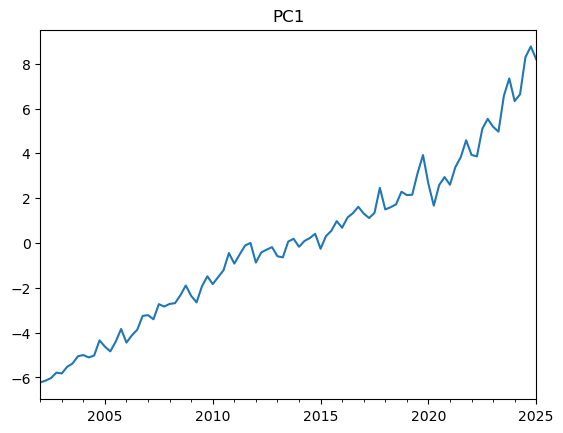

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

to_drop = ['CPI'] + many_missing_values

X = df1.select_dtypes(include='number').drop(columns=to_drop)
# for col in X.columns:
#     X[col] = X[col].pct_change(1)
X = X.dropna()
scaler = StandardScaler()
scaler = scaler.fit(X)
X_scaled = scaler.transform(X)

# from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(X=X_scaled)


np.round_(pca.explained_variance_ratio_,3)

# for i,j in enumerate(pca.explained_variance_ratio_):
#     print(f"PC{i+1}: {pca.explained_variance_ratio_[i]}")

# Obtain principle component scores
pcs = pca.transform(X_scaled)
pc = pd.DataFrame(pcs, columns=['PC1', 'PC2'])
pc.index = X.index

# Add principal components to data
df1 = pd.concat([df1, pc], axis=1)
pc['yq'] = pd.PeriodIndex(pc.index, freq='Q')
qpc = pc.groupby('yq').mean()

qpc = pd.concat([qpc, gdp], axis=1)

qpc['PC1'].plot(title='PC1', xlabel='')
plt.show()


## Elastic net

In [68]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA


#****************************
use_lags = True
#****************************

lags = {}
max_lag = 2

if use_lags:
    for col in stock_vars:
        for i in range(max_lag):
            lags[f"lag{i+1}_{col}"] = dfq[col].shift(i)

    dflags = pd.DataFrame(lags)
    dfq1 = pd.concat([dfq, dflags], axis=1)

    dfq = dfq1


try:
    dfq.drop(columns=many_missing_values,  inplace=True)
    dfq.dropna(inplace=True)
except Exception as e:
    print(f"Error: {e}")

# Define predictors and target
sa_series = [c for c in dfq.columns if re.search(r"sa_", str(c))]
su_series = [c for c in dfq.columns if not re.search(r"sa_", str(c))]
su_series = su_series[:]



if do_sa:
    X = dfq[sa_series].drop(columns=['sa_CPI','sa_GDP Actual'])
    y = np.log(dfq['sa_GDP Actual'])
    # y = (dfq['sa_GDP Actual'] - np.mean(dfq['sa_GDP Actual']))/np.std(dfq['sa_GDP Actual'])
else:
    X = dfq[su_series].drop(columns=['CPI','GDP Actual'])
    y = np.log(dfq['GDP Actual'])

#***********************************
use_growth = True
#***********************************

if use_growth:
    if do_sa:
        periods =1
    else:
        periods = 4 # For yoy quarterly changes we use 4, mom we use 1
    for col in X.columns:
        X[col] = X[col].pct_change(periods=periods)
    # for col in X.columns:
    #     X[col] = np.log(X[col])
    X = X.dropna()
    y = y.pct_change(periods=periods)
    y = y.dropna()
    # y = np.log(y)
    X_scaled = X
else:
# scale the variables
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X_scaled = scaler.transform(X)


# Fit Elastic Net model
alpha = 0.000019  # Controls overall regularization strength
l1_ratio = 0.4   # Balance between L1 (Lasso) and L2 (Ridge): 0=Ridge, 1=Lasso, 0.5=Equal mix

elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
elastic_net.fit(X_scaled, y)

# Extract coefficients and features
coef = pd.Series(elastic_net.coef_, index=X.columns)

# Keep only non-zero features (selected)
selected_features = coef[coef > 0].sort_values()
selected_features = selected_features.index.to_list()

#************************************************************************
# Override with manually selected features
if use_custom_weights:
    selected_features = list(custom_weights.keys())
#************************************************************************

print("Selected features:")
print(selected_features)

# Optional: Print model performance metrics
print(f"\nElastic Net Model Info:")
print(f"Alpha (regularization strength): {alpha}")
print(f"L1 ratio: {l1_ratio}")
print(f"Number of selected features: {len(selected_features)}")
print(f"Total features: {len(X.columns)}")

Selected features:
['Volume of oil imports', 'Import Value', 'Gold exports', 'Recurrent expenditure', 'Import volume', 'Cement production', 'Excise Duty', 'VAT', 'PAYE']

Elastic Net Model Info:
Alpha (regularization strength): 1.9e-05
L1 ratio: 0.4
Number of selected features: 9
Total features: 24


In [69]:
use_custom_weights

False

##  Compute mom symmetric change

In [70]:
# Add lagged variables to df1
lags = {}

if use_lags:
    for col in stock_vars:
        for i in range(max_lag):
            lags[f"lag{i+1}_{col}"] = df1[col].shift(i+1)

    dflags = pd.DataFrame(lags)
    df1 = pd.concat([df1, dflags], axis=1)

In [71]:
# sa_cols = [c for c in df1.columns[2:] if re.match(r"^sa_",str(c))]
sa_cols = [c for c in selected_features if not re.search(r'(?i)gdp', c)] #+ ['sa_Total  Expenditure', 'sa_Import Value']
su_cols = [c for c in selected_features if not re.search(r'(?i)gdp', c)] + ['Mobile payment Value']
# su_cols = [c for c in df1.columns[2:] if not re.match(r"^sa_",str(c))]

#*************************************************************************************************************
# Override with manual features

#*************************************************************************************************************
mom_change = {}
if do_sa:
    for col in sa_cols:
        mom_change[col] = 200*((df1[col]-df1[col].shift(1))/(df1[col]+df1[col].shift(1)))
else:
    for col in su_cols:
        mom_change[col] = 200*((df1[col]-df1[col].shift(1))/(df1[col]+df1[col].shift(1)))
mom_change = pd.DataFrame(mom_change)
dfchng = mom_change
# dfchng = pd.concat([df['Description'], mom_change], axis=1)
# dfchng

In [72]:
# df1

# Symmetric percentage changes - Visualization

In [73]:
cols = dfchng.columns

def lineplots(df):
    ncols = 4
    fig, axs = plt.subplots(ncols=ncols, nrows= 1+int(len(cols))//ncols, figsize = (20,15))

    axs = axs.ravel()

    for ax, col in zip(axs, cols):
        sns.lineplot(data=df, x= df.index, y=col, label='su', ax=ax)
        # sns.lineplot(data=df, x= df.index, y=f"sa_{col}", label='sa', ax=ax)
        ax.set_title(col)
    plt.tight_layout()    
if generate_plots:
    lineplots(dfchng)

In [74]:
# Compute standard deviations
inv_sd = {}
for col in dfchng.columns:
    inv_sd[col] = 1/np.std(dfchng[col][-68:-1])#[-120:-1])

In [75]:
# df['CPI'][-48:-1]
inv_sd

{'Volume of oil imports': 0.04103691263513429,
 'Import Value': 0.0741143205290703,
 'Gold exports': 0.06996263623632072,
 'Recurrent expenditure': 0.06988630553793912,
 'Import volume': 0.08620465344460715,
 'Cement production': 0.08488883318999052,
 'Excise Duty': 0.10869811149855961,
 'VAT': 0.09203181549985238,
 'PAYE': 0.11944238633853906,
 'Mobile payment Value': 0.11142109394809442}

In [76]:
# Normalize sd weights 
inv_sd_sum = sum(inv_sd.values())
inv_sd_normalized = {}
for k,v in inv_sd.items():
    inv_sd_normalized[k] = v/inv_sd_sum

inv_sd_normalized

{'Volume of oil imports': 0.04784601998228712,
 'Import Value': 0.08641184322359356,
 'Gold exports': 0.08157128488536775,
 'Recurrent expenditure': 0.08148228890868452,
 'Import volume': 0.10050828160365853,
 'Cement production': 0.09897413202580788,
 'Excise Duty': 0.12673399826731233,
 'VAT': 0.10730232370458853,
 'PAYE': 0.13926103199569065,
 'Mobile payment Value': 0.12990879540300904}

In [77]:
dfchng_adj = {}
for col in dfchng.columns:
    dfchng_adj[col] = inv_sd_normalized[col]*dfchng[col]

dfchng_adj = pd.DataFrame(dfchng_adj)

# Optimising weights

In [78]:
# Import weight optimizer from module codes
from codes.ciea_weight_optimizer import WeightOptimizer

In [79]:
# DE Optimization
# ===============================================
use_de_optimisation = False # Whether to use DE algorithm

if use_de_optimisation:
    print("Basic DE Optimization")
    print("-" * 40)

    # Initialize the optimizer
    optimizer_de = WeightOptimizer(dfchng_adj, gdp, base_year=2015, do_sa=False)

    # Method 1: Scipy optimization (recommended for most cases)
    print("Running DE optimization...")
    result_de = optimizer_de.optimize_weights_differential_evolution()

    # Get results
    optimal_weights_de = optimizer_de.get_optimal_weights()
    optimal_correlation_de = -result_de.fun
    print('_'*60)
    print(f"Optimal correlation: {optimal_correlation_de:.2f}")

In [80]:
# optimal_weights_de.keys()

In [81]:
def gen_weights_table(weight_dict):
    df = pd.DataFrame(weight_dict, index=[0]).T
    # dfw_de = dfw_de.T
    df.columns = ['weight']
    df.sort_values('weight', ascending=False, inplace=True)
    return df
if use_de_optimisation:    
    dfw_de = gen_weights_table(optimal_weights_de)
# dfw_de

In [82]:
if use_de_optimisation:
    qciea = optimizer_de.get_ciea_with_optimal_weights()
# qciea

## Optimized weights applied - DE

In [83]:
from codes.cieaplot import cieaplot
if use_de_optimisation:
    cieaplot(qciea)

## Composite indicator with equal weights

In [84]:
opt = WeightOptimizer(dfchng_adj, gdp)
qciea, weights = opt.calculate_ciea()
opt.compute_correlation(negate=False)

0.5328099668558628

In [85]:
# SCIPY Optimization
# ===============================================
print("SCIPY Optimization")
print("-" * 40)

# Initialize the optimizer
optimizer_sc = WeightOptimizer(dfchng_adj, gdp, base_year=2015, do_sa=False)

# Method 1: Scipy optimization (recommended for most cases)
print("Running scipy optimization...")
result_sc = optimizer_sc.optimize_weights_scipy(max_iterations=100000)

# Get results
optimal_weights_sc = optimizer_sc.get_optimal_weights()
optimal_correlation_sc = -result_sc.fun
print('_'*60)
print(f"Optimal correlation: {optimal_correlation_sc:.2f}")

SCIPY Optimization
----------------------------------------
Running scipy optimization...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5628732595298329
            Iterations: 25
            Function evaluations: 276
            Gradient evaluations: 25
____________________________________________________________
Optimal correlation: 0.56


In [86]:
dfw_sc = gen_weights_table(optimal_weights_sc)
# dfw_sc

In [87]:
qciea = optimizer_sc.get_ciea_with_optimal_weights()

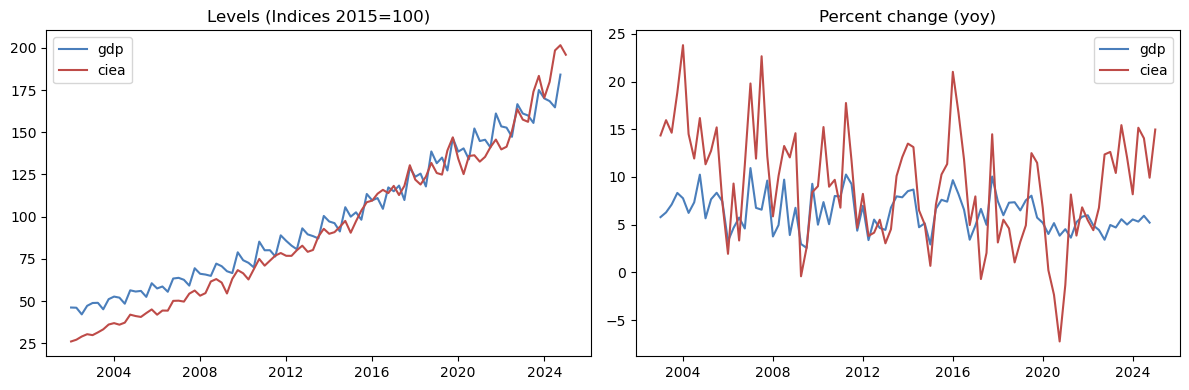

In [88]:
cieaplot(qciea)

## Correlation analysis by period

In [89]:
window_size = 22
n = qciea.dropna().shape[0]
chunks = n//window_size

to_remove = n%window_size
print(f"chunks: {chunks}, drop: {to_remove}")
# print(chunks, to_remove)


qciea1 = qciea.copy()
qciea0 = qciea1.loc[[c for c in range(to_remove+1)]]

qciea1 = qciea.drop(index=[i for i in range(to_remove+1)])
qciea1.reset_index(inplace = True, drop=True)
qciea1['yq'] = pd.PeriodIndex(qciea1['yq'],freq='Q')

qciea1.loc[[c for c in range(to_remove+1)]]

corr_dict = {}
for i in range(chunks):
     cor = qciea1.loc[window_size*i: window_size*i+window_size-1, ['yoy_ciea','yoy_gdp_index']].corr().iloc[0,1]
     cor = np.round_(cor,2)
     corr_dict[str(qciea1.loc[window_size*i, 'yq']) +'-' + str(qciea1.loc[window_size*i+window_size-1, 'yq'])] = cor


dfcorr = pd.DataFrame(corr_dict, index=[0]).T
dfcorr.columns = ['Correlation']
dfcorr.rename_axis('period',inplace=True)
dfcorr.to_excel('correlation_slices.xlsx')
print(dfcorr['Correlation'].mean())
dfcorr



chunks: 4, drop: 0
0.5449999999999999


,Correlation
period,
2002Q2-2007Q3,0.60
2007Q4-2013Q1,0.72
2013Q2-2018Q3,0.73
2018Q4-2024Q1,0.13


In [90]:
qciea1.loc[[c for c in range(to_remove+1)]]

,yq,ciea,gdp_index,yoy_ciea,yoy_gdp_index
0,2002Q2,27.148513,46.096098,NaN,NaN


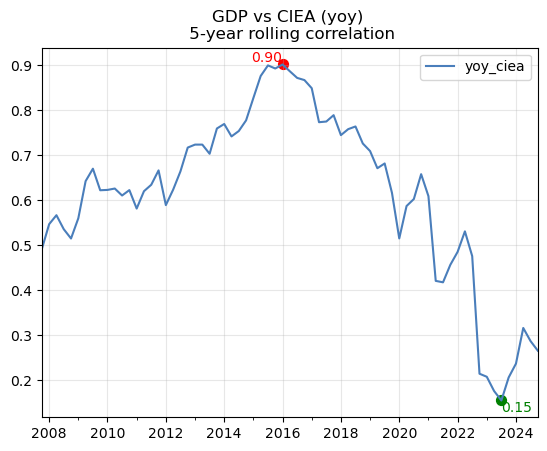

In [ ]:
# Rolling correlation

import matplotlib.cm as cm  # for colormap

# BOT COLORS
bot_colors = ["#4A7EBB", "#BE4B48", "#98B954", "#8064A2","#8C8278",
              "#46AAC5","#FABE64","#DCE6BE", "#C8FFFF", "#F79646","#2C4D75"]

qciea.index = qciea['yq']
roll_corr = qciea[['yoy_ciea']].rolling(20).corr(qciea['yoy_gdp_index'])
roll_corr = roll_corr.dropna()

# Set the index
qciea.index = pd.to_datetime(qciea['yq'])

# Calculate rolling correlation
roll_corr = qciea[['yoy_ciea']].rolling(20).corr(qciea['yoy_gdp_index'])
roll_corr.dropna(inplace=True)

# Find the date (index) and value of maximum correlation
max_corr_idx = pd.to_datetime(roll_corr['yoy_ciea'].idxmax())
max_corr_val = roll_corr['yoy_ciea'].max()


# Find the date (index) and value of minimum correlation
min_corr_idx = pd.to_datetime(roll_corr['yoy_ciea'].idxmin())
min_corr_val = roll_corr['yoy_ciea'].min()


# Plot with customizations
ax = roll_corr.plot(title='GDP vs CIEA (yoy) \n 5-year rolling correlation',
                    color=bot_colors[0])


# Remove x-axis label
ax.set_xlabel('')
ax.grid(True, alpha=0.3)

# Add scatter plot for max correlation
ax.scatter(max_corr_idx, max_corr_val, color='red', s=50, label='Max Corr')
ax.text(max_corr_idx, max_corr_val, f'{max_corr_val:.2f}', verticalalignment='bottom', 
        horizontalalignment='right', color='red')

# Add scatter plot for min correlation
ax.scatter(min_corr_idx, min_corr_val, color='green', s=50, label='Min Corr')
ax.text(min_corr_idx, min_corr_val, f'{min_corr_val:.2f}', verticalalignment='top', 
        horizontalalignment='left', color='green')

# ax.get_legend().remove()

plt.show()

In [92]:
roll_corr.dropna()

,yoy_ciea
yq,
2007-10-01,0.549221
2008-01-01,0.606721
2008-04-01,0.626463
2008-07-01,0.604632
2008-10-01,0.569635
...,...
2023-10-01,0.216683
2024-01-01,0.262367
2024-04-01,0.339725


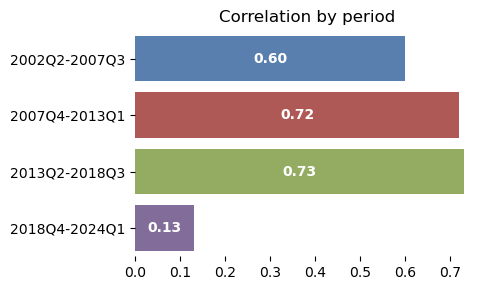

In [93]:

plt.figure(figsize=(5, 3))
ax = sns.barplot(data=dfcorr, y=dfcorr.index, x='Correlation', orient='h', palette=bot_colors)

for i, container in enumerate(ax.containers):
    bars = container
    for j, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width/2, bar.get_y() + bar.get_height()/2., f'{width:.2f}',
                ha='center', va='center', color='white', fontweight='bold')

ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Correlation by period')
plt.tight_layout()
plt.savefig('corr_byperiod.png')
plt.show()

## Export weights  to excel
- The table shows weights optimised by two algorithms `Differential Evolution (DE)` and `Sequential Least Squares Programming (SLSP)`
- **DE** is slower, we may opt to switch it off
- In this case we use weights only derived from **SLSP**

In [94]:
if use_de_optimisation:
    df_weights = pd.concat([dfw_de, dfw_sc], axis=1)
    df_weights.columns = ['DE', 'SLSP']
else:
    df_weights = dfw_sc
    df_weights.columns = ['SLSP']


df_weights.rename_axis('Indicator', inplace=True)
df_weights.to_excel('optimal_weights.xlsx')

## Standard weights applied

In [95]:
# qciea['yq'] = qciea['yq'].dt.to_period(freq='Q')
# qciea['yq'] = qciea['yq'].astype(str)
optimizer = WeightOptimizer(dfchng_adj, gdp, base_year=2015, do_sa=False)
qciea, weights = optimizer.calculate_ciea()

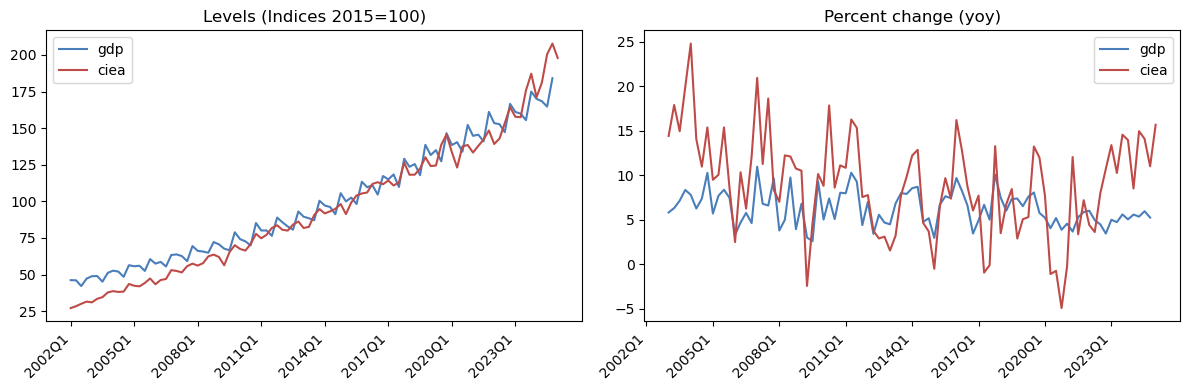

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

bot_colors = ["#4A7EBB", "#BE4B48", "#98B954", "#8064A2","#8C8278","#46AAC5","#FABE64","#DCE6BE", "#C8FFFF", "#F79646","#2C4D75"]


def cieaplot(df):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    axs = axs.ravel()

    # Convert 'yq' to string for proper labeling
    df['yq'] = pd.PeriodIndex(df['yq'], freq='Q')
    df['yq'] = df['yq'].astype(str)

    # Left plot - Levels
    sns.lineplot(data=df, x='yq', y='gdp_index', label='gdp', ax=axs[0], color=bot_colors[0])
    sns.lineplot(data=df, x='yq', y='ciea', label='ciea', ax=axs[0], color=bot_colors[1])
    axs[0].set_title('Levels (Indices 2015=100)')
    axs[0].set_xlabel("")
    axs[0].set_ylabel("")
    axs[0].legend()

    # Right plot - YoY changes
    sns.lineplot(data=df, x='yq', y='yoy_gdp_index', label='gdp', ax=axs[1], color=bot_colors[0])
    sns.lineplot(data=df, x='yq', y='yoy_ciea', label='ciea', ax=axs[1], color=bot_colors[1])
    axs[1].set_title('Percent change (yoy)')
    axs[1].set_xlabel("")
    axs[1].set_ylabel("")
    axs[1].legend()

    # Remove spines for cleaner look
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

        # Set x-axis tick interval. Adjust the '4' based on your data frequency.
        # For quarterly data, 4 means labels every year. For annual, maybe 1 or 2.
        tick_interval = 12 # Example: show every 4th label
        ax.set_xticks(ax.get_xticks()[::tick_interval])
        ax.set_xticklabels(df['yq'][::tick_interval], rotation=45, ha='right') # Rotate for better readability if needed
   
    plt.tight_layout()
    plt.savefig("ciea_gdp.png", dpi=300, bbox_inches='tight')
    plt.show()

cieaplot(qciea)

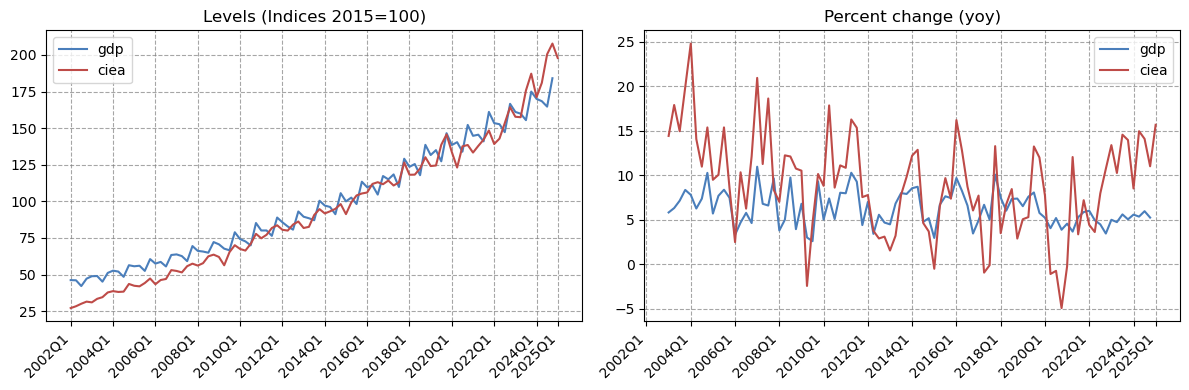

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

bot_colors = ["#4A7EBB", "#BE4B48", "#98B954", "#8064A2","#8C8278","#46AAC5","#FABE64","#DCE6BE", "#C8FFFF", "#F79646","#2C4D75"]


def cieaplot(df):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    axs = axs.ravel()

    # Ensure 'yq' is treated as a string/categorical variable for plotting
    df['yq'] = df['yq'].astype(str)

    # Left plot - Levels
    sns.lineplot(data=df, x='yq', y='gdp_index', label='gdp', ax=axs[0], color=bot_colors[0])
    sns.lineplot(data=df, x='yq', y='ciea', label='ciea', ax=axs[0], color=bot_colors[1])
    axs[0].set_title('Levels (Indices 2015=100)')
    axs[0].set_xlabel("")
    axs[0].set_ylabel("")
    axs[0].legend()

    # Right plot - YoY changes
    sns.lineplot(data=df, x='yq', y='yoy_gdp_index', label='gdp', ax=axs[1], color=bot_colors[0])
    sns.lineplot(data=df, x='yq', y='yoy_ciea', label='ciea', ax=axs[1], color=bot_colors[1])
    axs[1].set_title('Percent change (yoy)')
    axs[1].set_xlabel("")
    axs[1].set_ylabel("")
    axs[1].legend()

    # Remove top and right spines for a cleaner look
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

        # Determine tick interval
        total_quarters = len(df['yq'].unique())
        if total_quarters > 40: # For very long series, show fewer labels
            tick_interval = 8
        elif total_quarters > 20:
            tick_interval = 4
        else: # For shorter series, show more labels
            tick_interval = 2

        # --- Modified part to ensure last label is shown ---
        # Get base ticks and labels based on interval
        x_ticks_base = df.index[::tick_interval].tolist()
        x_labels_base = df['yq'].iloc[::tick_interval].tolist()

        # Check if the last data point's index is not already in our chosen ticks
        if df.index[-1] not in x_ticks_base:
            x_ticks_base.append(df.index[-1])
            x_labels_base.append(df['yq'].iloc[-1])

        # Set x-axis ticks and labels
        ax.set_xticks(x_ticks_base)
        ax.set_xticklabels(x_labels_base, rotation=45, ha='right') # Rotate for better readability
        # --- End of modified part ---

        # Add both horizontal and vertical gridlines
        ax.grid(which='major', linestyle='--', alpha=0.7, color='gray')
   
    plt.tight_layout()
    plt.savefig("ciea_gdp.png", dpi=300, bbox_inches='tight')
    plt.show()

cieaplot(qciea)